# Emissions-driven GSAT attributions

Theme Song: Electric Sunrise<br>
Artist: Plini<br>
Album: Handmade Cities<br>
Released: 2016

- Run two layer model with AR6 forcing, but using constrained-correlated parameter setups
- unlike 210, we now scale each individual forcing by its emission-driven estimate from Sara
- Use constrained FaIR setup from 160

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
emissions = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')|
        (emissions.Variable=='Emissions|VOC')|
        (emissions.Variable=='Emissions|CO')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
        'Emissions|VOC': 'VOC',
        'Emissions|CO': 'CO'
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx', 'VOC', 'CO']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

emissions_ceds_update = emissions.copy()

emissions_old = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), 'Variable'], emissions_old.loc[(
        (emissions_old.Variable=='Emissions|BC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|OC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|CO|MAGICC Fossil and Industrial')|
        (emissions_old.Variable=='Emissions|BC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|OC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|Sulfur|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NOx|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|NH3|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|VOC|MAGICC AFOLU|Agriculture')|
        (emissions_old.Variable=='Emissions|CO|MAGICC AFOLU|Agriculture')
    ) & (emissions_old.Scenario=='ssp245') & (emissions_old.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
for species in ['BC', 'OC', 'Sulfur', 'NOx', 'NH3', 'VOC', 'CO']:
    df_emissions[species] = df_emissions['Emissions|{}|MAGICC Fossil and Industrial'.format(species)] + df_emissions['Emissions|{}|MAGICC AFOLU|Agriculture'.format(species)]
df_emissions.rename(columns = {'Sulfur': 'SO2'}, inplace=True)
df_emissions.drop(columns=[
        'Emissions|BC|MAGICC Fossil and Industrial',
        'Emissions|OC|MAGICC Fossil and Industrial',
        'Emissions|Sulfur|MAGICC Fossil and Industrial',
        'Emissions|NOx|MAGICC Fossil and Industrial',
        'Emissions|NH3|MAGICC Fossil and Industrial',
        'Emissions|VOC|MAGICC Fossil and Industrial',
        'Emissions|CO|MAGICC Fossil and Industrial',
        'Emissions|BC|MAGICC AFOLU|Agriculture',
        'Emissions|OC|MAGICC AFOLU|Agriculture',
        'Emissions|Sulfur|MAGICC AFOLU|Agriculture',
        'Emissions|NOx|MAGICC AFOLU|Agriculture',
        'Emissions|NH3|MAGICC AFOLU|Agriculture',
        'Emissions|VOC|MAGICC AFOLU|Agriculture',
        'Emissions|CO|MAGICC AFOLU|Agriculture',
    ],
    inplace=True
)
df_emissions.index = emissions.index.astype('int')
df_emissions.index.name='year'
df_emissions.columns.name=None

global_total = {}
for species in ['BC', 'OC', 'SO2', 'NH3', 'NOx', 'NMVOC', 'CO']:
    df = pd.read_csv('../data_input_large/CEDS_v_2020_09_11_emissions/{}_global_CEDS_emissions_by_sector_2020_09_11.csv'.format(species))
    global_total[species] = df.sum(axis=0).values[3:].astype(float) / 1000 
    #unit = df.units[0]
    #print(unit)
global_total['VOC'] = global_total.pop('NMVOC')
new_ceds = pd.DataFrame(global_total)
new_ceds.index = np.arange(1750,2020)
new_ceds.index = new_ceds.index.astype('int')
new_ceds.index.name='year'
new_ceds.columns.name=None
emissions_ceds_update = new_ceds.loc[1750:2020] + emissions - df_emissions
emissions_ceds_update.drop(index=range(2020,2101), inplace=True)
emissions_ceds_update

,BC,CO,NH3,NOx,OC,SO2,VOC
year,,,,,,,
1750,2.097336,348.420476,6.683996,12.730074,15.447054,2.312083,60.599376
1751,2.072491,343.819148,6.615537,12.587160,15.188102,2.281498,59.667759
1752,2.063877,341.701465,6.573965,12.589121,15.033861,2.270899,59.213713
1753,2.071515,343.567551,6.635011,12.534665,15.181930,2.284976,59.610148
1754,2.098914,349.707369,6.767852,12.631676,15.558158,2.336934,60.855827
...,...,...,...,...,...,...,...
2015,7.992567,894.144647,62.462922,138.718989,30.046634,91.076152,213.006570
2016,7.918346,874.700320,63.054904,137.128483,30.086767,87.215738,211.778440
2017,7.886938,867.879243,63.739495,137.159668,30.057079,84.269791,211.717165


## Climate model parameters

### load unconstrained

In [4]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [5]:
accept_inds

array([   156,    358,    441, ..., 998289, 998908, 999021])

In [6]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
156,6.419499,-1.714643,8.810878,448.213437,0.440273,0.347264
358,8.646745,-1.817834,9.691545,103.494497,0.772469,1.585394
441,8.316302,-2.085561,5.696549,180.474488,0.821490,1.251474
636,7.889668,-0.796998,7.735094,89.445554,0.852359,1.535440
914,7.034846,-1.315331,8.992672,168.484833,0.709503,1.100228
...,...,...,...,...,...,...
996792,7.585270,-1.281183,8.745431,62.417455,0.755601,1.668154
996846,7.574501,-1.881943,9.089493,452.306881,0.565309,0.532951
998289,7.528928,-1.436389,7.878012,109.737561,0.522615,1.350649
998908,8.727801,-1.409111,9.221984,128.496448,0.521846,1.581632


In [7]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# carbon cycle
pre_ind_co2 = pre_ind_co2[accept_inds]
r0 = r0[accept_inds]
rC = rC[accept_inds]
rT = rT[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [8]:
f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

(array([121., 574., 807., 474., 185.,  37.,  10.,  16.,  10.,   3.]),
 array([6.80758831e-04, 3.38060015e-01, 6.75439272e-01, 1.01281853e+00,
        1.35019778e+00, 1.68757704e+00, 2.02495630e+00, 2.36233555e+00,
        2.69971481e+00, 3.03709407e+00, 3.37447332e+00]),
 <a list of 10 Patch objects>)

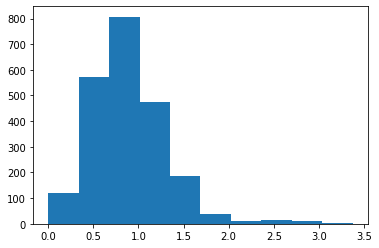

In [9]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

In [10]:
lamg = geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

## Forcing uncertainties - ensure consistency with 040

### Aerosol emissions

In [11]:
ERFari = np.zeros((270, len(accept_inds)))
ERFaci = np.zeros((270, len(accept_inds)))

so2 = emissions_ceds_update.loc[:,'SO2']
bc = emissions_ceds_update.loc[:,'BC']
oc = emissions_ceds_update.loc[:,'OC']
nh3 = emissions_ceds_update.loc[:,'NH3']

for i in tqdm(range(len(accept_inds))):
    ERFari[:, i] = (
        (emissions_ceds_update.loc[:,'SO2']-emissions_ceds_update.loc[1750,'SO2']) * beta_so2[i] * 32/64 +
        (emissions_ceds_update.loc[:,'BC']-emissions_ceds_update.loc[1750,'BC']) * beta_bc[i] +
        (emissions_ceds_update.loc[:,'OC']-emissions_ceds_update.loc[1750,'OC']) * beta_oc[i] +
        (emissions_ceds_update.loc[:,'NH3']-emissions_ceds_update.loc[1750,'NH3']) * beta_nh3[i]
    )
    
    ERFaci[:,i] = ghan([so2 * 32/64, bc+oc], beta[i], aci_coeffs[i,0], aci_coeffs[i,1]) - ghan([so2[1750] * 32/64, bc[1750]+oc[1750]], beta[i], aci_coeffs[i,0], aci_coeffs[i,1])

  0%|          | 0/2237 [00:00<?, ?it/s]

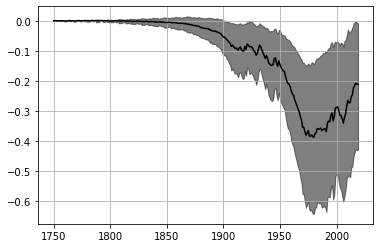

In [12]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari, 5, axis=1), np.percentile(ERFari, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari, 50, axis=1), color='k')
pl.grid()

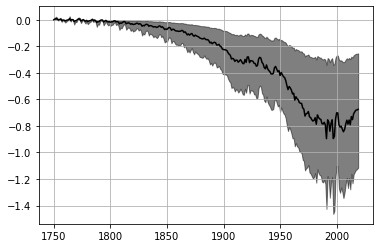

In [13]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFaci, 5, axis=1), np.percentile(ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFaci, 50, axis=1), color='k')
pl.grid()

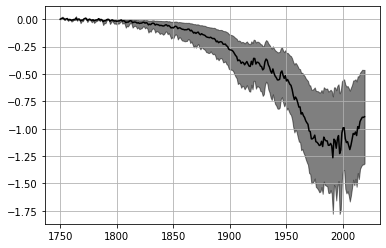

In [14]:
pl.fill_between(np.arange(1750, 2020), np.percentile(ERFari+ERFaci, 5, axis=1), np.percentile(ERFari+ERFaci, 95, axis=1), color='k', alpha=0.5)
pl.plot(np.arange(1750,2020), np.percentile(ERFari+ERFaci, 50, axis=1), color='k')
pl.grid()

## get Sara's numbers

In [15]:
forcing_by_emissions = pd.read_csv('../data_input/chapter6_emissions_attribution/2019_ERF_est.csv', index_col=0)
forcing_by_emissions.rename(
    columns={
        'CO2': 'co2',
        'CH4_lifetime': 'ch4',
        'Strat_H2O': 'h2o_stratospheric',
        'Aerosol': 'aerosol-radiation_interactions',
        'Cloud': 'aerosol-cloud_interactions',
        'O3': 'o3',
        'HC': 'other_wmghg',
        'N2O': 'n2o'
    },
    index = {
        'CO2': 'co2',
        'CH4': 'ch4',
        'N2O': 'n2o',
        'HC': 'other_wmghg',
    },
    inplace=True
)
forcing_by_emissions.drop(columns='HFCs', inplace=True)
forcing_by_emissions_ratio = forcing_by_emissions / forcing_by_emissions.sum(axis=0)
forcing_by_emissions_ratio

,co2,ch4,h2o_stratospheric,aerosol-radiation_interactions,aerosol-cloud_interactions,o3,other_wmghg,n2o
emission_experiment,,,,,,,,
co2,0.959391,0.000000,0.0,-0.000000,-0.000000,0.000000,0.0,0.0
ch4,0.008183,1.563808,1.0,0.015673,-0.021930,0.593998,0.0,0.0
n2o,0.000000,-0.066606,0.0,0.012349,-0.050599,0.051725,0.0,1.0
other_wmghg,0.000025,-0.094309,0.0,0.047732,0.020737,-0.350183,1.0,0.0
NOx,0.000000,-0.703749,0.0,0.054144,0.017212,0.255823,0.0,0.0
VOC,0.032402,0.300856,0.0,0.015198,-0.010576,0.448638,0.0,0.0
SO2,0.000000,0.000000,0.0,0.975919,0.814268,0.000000,0.0,0.0
OC,0.000000,0.000000,0.0,0.300588,0.158413,0.000000,0.0,0.0
BC,0.000000,0.000000,0.0,-0.562303,0.072474,0.000000,0.0,0.0


### Non-aerosol forcings and aggregated categories

In [16]:
scale_normals.shape

(2237, 11)

In [18]:
df = pd.read_csv('../data_output/AR6_ERF_1750-2019.csv')
forcing_ensemble = {}
#for cat in ['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric', 'contrails', 'aerosol-radiation_interactions',
##           'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'solar', 'volcanic', 'wmghgs', 'aerosol', 'albedo',
#           'anthro', 'natural']:
#    forcing_ensemble[cat] = np.zeros((270, len(accept_inds)))
    
# naming convention: emissions_resulting-forcing
forcing_ensemble['co2_co2'] = df['co2'].values[:,None] * scale_normals[:,0] * forcing_by_emissions_ratio.loc['co2', 'co2']
forcing_ensemble['ch4_co2'] = df['co2'].values[:,None] * scale_normals[:,0] * forcing_by_emissions_ratio.loc['ch4', 'co2']
forcing_ensemble['oth_co2'] = df['co2'].values[:,None] * scale_normals[:,0] * forcing_by_emissions_ratio.loc['other_wmghg', 'co2']
forcing_ensemble['voc_co2'] = df['co2'].values[:,None] * scale_normals[:,0] * forcing_by_emissions_ratio.loc['VOC', 'co2']

forcing_ensemble['ch4_ch4'] = df['ch4'].values[:,None] * scale_normals[:,1] * forcing_by_emissions_ratio.loc['ch4', 'ch4']
forcing_ensemble['n2o_ch4'] = df['ch4'].values[:,None] * scale_normals[:,1] * forcing_by_emissions_ratio.loc['n2o', 'ch4']
forcing_ensemble['oth_ch4'] = df['ch4'].values[:,None] * scale_normals[:,1] * forcing_by_emissions_ratio.loc['other_wmghg', 'ch4']
forcing_ensemble['nox_ch4'] = df['ch4'].values[:,None] * scale_normals[:,1] * forcing_by_emissions_ratio.loc['NOx', 'ch4']
forcing_ensemble['voc_ch4'] = df['ch4'].values[:,None] * scale_normals[:,1] * forcing_by_emissions_ratio.loc['VOC', 'ch4']

forcing_ensemble['n2o_n2o'] = df['n2o'].values[:,None] * scale_normals[:,2]

forcing_ensemble['oth_oth'] = df['other_wmghg'].values[:,None] * scale_normals[:,3]

forcing_ensemble['ch4_ozo'] = df['o3'].values[:,None] * scale_normals[:,4] * forcing_by_emissions_ratio.loc['ch4', 'o3']
forcing_ensemble['n2o_ozo'] = df['o3'].values[:,None] * scale_normals[:,4] * forcing_by_emissions_ratio.loc['n2o', 'o3']
forcing_ensemble['oth_ozo'] = df['o3'].values[:,None] * scale_normals[:,4] * forcing_by_emissions_ratio.loc['other_wmghg', 'o3']
forcing_ensemble['nox_ozo'] = df['o3'].values[:,None] * scale_normals[:,4] * forcing_by_emissions_ratio.loc['NOx', 'o3']
forcing_ensemble['voc_ozo'] = df['o3'].values[:,None] * scale_normals[:,4] * forcing_by_emissions_ratio.loc['VOC', 'o3']

forcing_ensemble['ch4_h2o'] = df['h2o_stratospheric'].values[:,None] * scale_normals[:,5]

forcing_ensemble['con_con'] = df['contrails'].values[:,None] * scale_normals[:,6]

forcing_ensemble['ch4_ari'] = ERFari * forcing_by_emissions_ratio.loc['ch4', 'aerosol-radiation_interactions']
forcing_ensemble['n2o_ari'] = ERFari * forcing_by_emissions_ratio.loc['n2o', 'aerosol-radiation_interactions']
forcing_ensemble['oth_ari'] = ERFari * forcing_by_emissions_ratio.loc['other_wmghg', 'aerosol-radiation_interactions']
forcing_ensemble['nox_ari'] = ERFari * forcing_by_emissions_ratio.loc['NOx', 'aerosol-radiation_interactions']
forcing_ensemble['voc_ari'] = ERFari * forcing_by_emissions_ratio.loc['VOC', 'aerosol-radiation_interactions']
forcing_ensemble['so2_ari'] = ERFari * forcing_by_emissions_ratio.loc['SO2', 'aerosol-radiation_interactions']
forcing_ensemble['blc_ari'] = ERFari * forcing_by_emissions_ratio.loc['BC', 'aerosol-radiation_interactions']
forcing_ensemble['orc_ari'] = ERFari * forcing_by_emissions_ratio.loc['OC', 'aerosol-radiation_interactions']
forcing_ensemble['nh3_ari'] = ERFari * forcing_by_emissions_ratio.loc['NH3', 'aerosol-radiation_interactions']

forcing_ensemble['ch4_aci'] = ERFaci * forcing_by_emissions_ratio.loc['ch4', 'aerosol-cloud_interactions']
forcing_ensemble['n2o_aci'] = ERFaci * forcing_by_emissions_ratio.loc['n2o', 'aerosol-cloud_interactions']
forcing_ensemble['oth_aci'] = ERFaci * forcing_by_emissions_ratio.loc['other_wmghg', 'aerosol-cloud_interactions']
forcing_ensemble['nox_aci'] = ERFaci * forcing_by_emissions_ratio.loc['NOx', 'aerosol-cloud_interactions']
forcing_ensemble['voc_aci'] = ERFaci * forcing_by_emissions_ratio.loc['VOC', 'aerosol-cloud_interactions']
forcing_ensemble['so2_aci'] = ERFaci * forcing_by_emissions_ratio.loc['SO2', 'aerosol-cloud_interactions']
forcing_ensemble['blc_aci'] = ERFaci * forcing_by_emissions_ratio.loc['BC', 'aerosol-cloud_interactions']
forcing_ensemble['orc_aci'] = ERFaci * forcing_by_emissions_ratio.loc['OC', 'aerosol-cloud_interactions']

forcing_ensemble['blc_bcs'] = df['bc_on_snow'].values[:,None] * scale_normals[:,7]

forcing_ensemble['luc_luc'] = df['land_use'].values[:,None] * scale_normals[:,8]

forcing_ensemble['anthro'] = (
    forcing_ensemble['co2_co2'] +
    forcing_ensemble['ch4_co2'] +
    forcing_ensemble['oth_co2'] +
    forcing_ensemble['voc_co2'] +
    forcing_ensemble['ch4_ch4'] +
    forcing_ensemble['n2o_ch4'] +
    forcing_ensemble['oth_ch4'] +
    forcing_ensemble['nox_ch4'] +
    forcing_ensemble['voc_ch4'] +
    forcing_ensemble['n2o_n2o'] +
    forcing_ensemble['oth_oth'] +
    forcing_ensemble['ch4_ozo'] +
    forcing_ensemble['n2o_ozo'] +
    forcing_ensemble['oth_ozo'] +
    forcing_ensemble['nox_ozo'] +
    forcing_ensemble['voc_ozo'] +
    forcing_ensemble['ch4_h2o'] +
    forcing_ensemble['con_con'] +
    forcing_ensemble['ch4_ari'] +
    forcing_ensemble['n2o_ari'] +
    forcing_ensemble['oth_ari'] +
    forcing_ensemble['nox_ari'] +
    forcing_ensemble['voc_ari'] +
    forcing_ensemble['so2_ari'] +
    forcing_ensemble['blc_ari'] +
    forcing_ensemble['orc_ari'] +
    forcing_ensemble['nh3_ari'] +
    forcing_ensemble['ch4_aci'] +
    forcing_ensemble['n2o_aci'] +
    forcing_ensemble['oth_aci'] +
    forcing_ensemble['nox_aci'] +
    forcing_ensemble['voc_aci'] +
    forcing_ensemble['so2_aci'] +
    forcing_ensemble['blc_aci'] +
    forcing_ensemble['orc_aci'] +
    forcing_ensemble['blc_bcs'] +
    forcing_ensemble['luc_luc']
)

In [19]:
forcing_ensemble['anthro'].shape

(270, 2237)

# Run climate model

In [20]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)

In [21]:
cmix_mean = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep_mean = cmip6_models['cdeep']['mean']['EBM-epsilon']
eff_mean = cmip6_models['eff']['mean']['EBM-epsilon']

lamg_median = f2x_median/ecs_median
kappa_median = -(f2x_median/ecs_median - f2x_median/tcr_median)
gamma_2l_median = kappa_median/eff_mean

In [22]:
gamma_2l_median, kappa_median, lamg_median, eff_mean, cmix_mean, cdeep_mean

(0.6395952745483992,
 0.85785768256684,
 1.3670409092103908,
 1.3412508139190835,
 8.144224615560551,
 109.62536045769089)

In [23]:
results = {}

In [24]:
forcing_ensemble.keys()

dict_keys(['co2_co2', 'ch4_co2', 'oth_co2', 'voc_co2', 'ch4_ch4', 'n2o_ch4', 'oth_ch4', 'nox_ch4', 'voc_ch4', 'n2o_n2o', 'oth_oth', 'ch4_ozo', 'n2o_ozo', 'oth_ozo', 'nox_ozo', 'voc_ozo', 'ch4_h2o', 'con_con', 'ch4_ari', 'n2o_ari', 'oth_ari', 'nox_ari', 'voc_ari', 'so2_ari', 'blc_ari', 'orc_ari', 'nh3_ari', 'ch4_aci', 'n2o_aci', 'oth_aci', 'nox_aci', 'voc_aci', 'so2_aci', 'blc_aci', 'orc_aci', 'blc_bcs', 'luc_luc', 'anthro'])

## 270-year forcing runs

- forcing and climate variation

In [25]:
arglist = []

lamg = -geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values


for i in range(len(accept_inds)):
    arglist.append(
        {
            'cmix': cmix[i],
            'cdeep': cdeep[i],
            'gamma_2l': gamma_2l[i],
            'lamg': lamg[i],
            'eff': eff[i],
            'in_forcing' : forcing_ensemble['anthro'][:,i],
            'firstyear': 1750
        }
    )

results['AR6-anthro_climuncert'] = {}

def run_tlm(args):
    in_forcing = args['in_forcing']
    driver = TwoLayerModel(
        extforce=in_forcing,
        exttime=np.arange(args['firstyear'],2020),
        tbeg=args['firstyear'],
        tend=2020,
        lamg=args['lamg'],
        t2x=None,
        eff=args['eff'],
        cmix=args['cmix'],
        cdeep=args['cdeep'],
        gamma_2l=args['gamma_2l'],
        outtime=np.arange(1750,2020),
        dt=0.2
    )
    output = driver.run()
    return(output.tg)
    
    
if __name__ == '__main__':
    with Pool(24) as pool:
        result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds)))
    output = np.array(result).T

results['AR6-anthro_climuncert']['effective_radiative_forcing'] = forcing_ensemble['anthro']
results['AR6-anthro_climuncert']['surface_temperature'] = output

  0%|          | 0/2237 [00:00<?, ?it/s]

In [26]:
results['AR6-anthro_climuncert']['surface_temperature'].shape

(270, 2237)

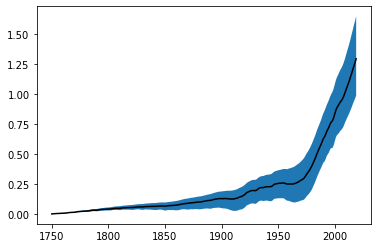

In [27]:
pl.fill_between(np.arange(1750, 2020),
                np.percentile(results['AR6-anthro_climuncert']['surface_temperature'], 5, axis=1),
                np.percentile(results['AR6-anthro_climuncert']['surface_temperature'], 95, axis=1),
               )
pl.plot(np.arange(1750, 2020), np.median(results['AR6-anthro_climuncert']['surface_temperature'], axis=1), color='k')

## Marginal contributions since 1750

- forcing and climate variation

In [28]:
if __name__ == '__main__':
    for agent in tqdm(list(forcing_ensemble.keys())[:-1], desc='Removing one at a time'):
        arglist = []
        for i in range(len(accept_inds)):
            startindex=0
            firstyear = 1750
            in_forcing = forcing_ensemble['anthro'][startindex:,i] - forcing_ensemble[agent][startindex:,i]
            arglist.append(
                {
                    'in_forcing' : in_forcing,
                    'cmix': cmix[i],
                    'cdeep': cdeep[i],
                    'gamma_2l': gamma_2l[i],
                    'lamg': lamg[i],
                    'eff': eff[i],
                    'firstyear': firstyear
                }
            )
        output = []
        results['remove_%s_climuncert' % agent] = {}
        with Pool(24) as pool:
            result = list(tqdm(pool.imap(run_tlm, arglist), total=len(accept_inds), leave=False))
        output = np.array(result).T

        results['remove_%s_climuncert' % agent]['effective_radiative_forcing'] = forcing_ensemble['anthro'] - forcing_ensemble[agent]
        results['remove_%s_climuncert' % agent]['surface_temperature'] = output

Removing one at a time:   0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

  0%|          | 0/2237 [00:00<?, ?it/s]

In [29]:
save_dict_to_hdf5(results, '../data_output_large/twolayer_AR6-historical-emissions-based.h5')